# **라이브러리 로드**

In [5]:
import pandas as pd
import numpy as np
import tarfile
import pickle
import os


# 데이터 전처리 패키지
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#모델 패키지
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dropout

# 시각화 패키지
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

2024-12-09 02:17:10.407694: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 02:17:10.433850: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 02:17:10.828532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **차원 축소 - 변수 추출법**

## **1. 주성분 분석(PCA)**

### **데이터 불러오기**

breast-cancer.csv
- 유방 종양의 30개 물리적 특성 관련 지표
- 목표 변수 : Diagnosis(악성M/양성B)

In [ ]:
# Breast cancer dataset


### **시각화 함수**

In [7]:
def plot_labelled_scatter(X, y, class_labels, s):
    le = LabelEncoder()  # 라벨 데이터를 숫자로 변환하는 인코더 초기화
    y_encoded = le.fit_transform(y)  # 클래스 레이블('M', 'B' 등)을 숫자로 변환
    num_labels = len(class_labels)  # 클래스 레이블의 총 개수

    # 데이터의 x축과 y축 범위 설정
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # 마커와 색상 설정
    marker_array = ['o', '^', '*']  # 각 클래스의 마커 스타일
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']  # 각 클래스의 색상
    cmap_bold = ListedColormap(color_array)  # 강한 색상을 위한 컬러맵 생성
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)  # 클래스 경계를 위한 색상 정규화

    plt.figure(figsize=s)  # 그래프 크기 설정

    # 산점도 그리기
    plt.scatter(X[:, 0], X[:, 1], s=80, c=y_encoded, cmap=cmap_bold, norm=bnorm,
                alpha=0.4, edgecolor='black', lw=1)  # 점 크기, 색상, 투명도 및 테두리 설정

    # 그래프의 상단과 오른쪽 축 숨기기
    sp = plt.gca().spines  # 현재 축의 경계를 가져옴
    sp['top'].set_visible(False)  # 상단 경계 숨기기
    sp['right'].set_visible(False)  # 오른쪽 경계 숨기기

    plt.grid(which='both', color='lightslategrey', alpha=0.3)  # 격자 표시 설정

    # x축과 y축 범위 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 범례 추가
    h = []  # 범례 핸들 리스트
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))  # 각 클래스의 색상과 레이블 추가
    plt.legend(handles=h, fontsize=15, frameon=False)  # 범례 스타일 설정

### **1-1. PCA 적용**

In [ ]:
# 데이터를 평균 0, 분산 1로 표준화하여 PCA 적용 전에 정규화

# PCA(주성분 분석)를 사용하여 데이터의 주성분 2개를 추출하도록 모델을 학습

# 학습된 PCA 모델로 데이터를 변환하여 2개의 주성분으로 차원을 축소

# PCA 전후의 데이터 특징 수 출력 (PCA 적용 전의 특징 수와 축소 후의 특징 수 비교)

Number of Features in Breast Cancer DataSet Before PCA : 30

Number of Features in Breast Cancer DataSet After PCA : 2


### **1-2 PCA 결과 시각화**

Text(0.5, 1.0, 'Breast Cancer Dataset PCA (n_components = 2)')

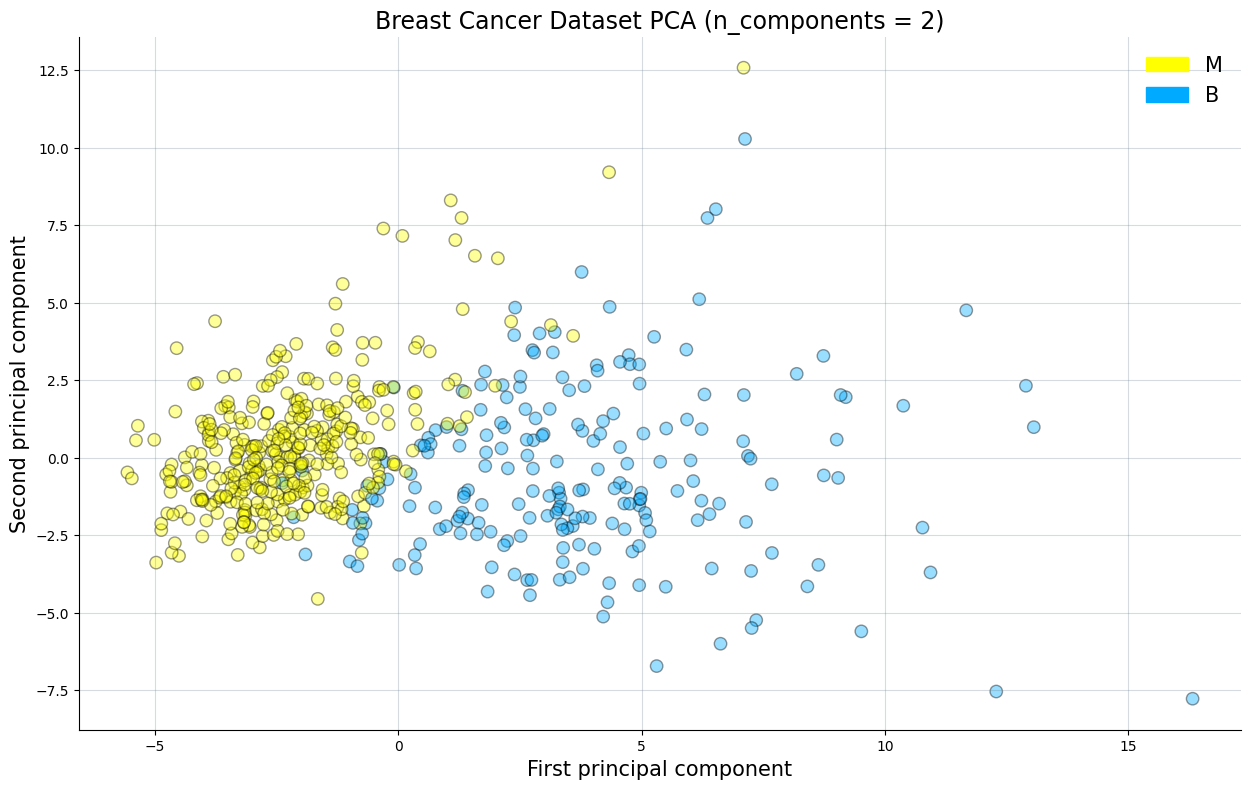

### **1-3 PCA 결과와 기존 feature의 상관관계 확인**

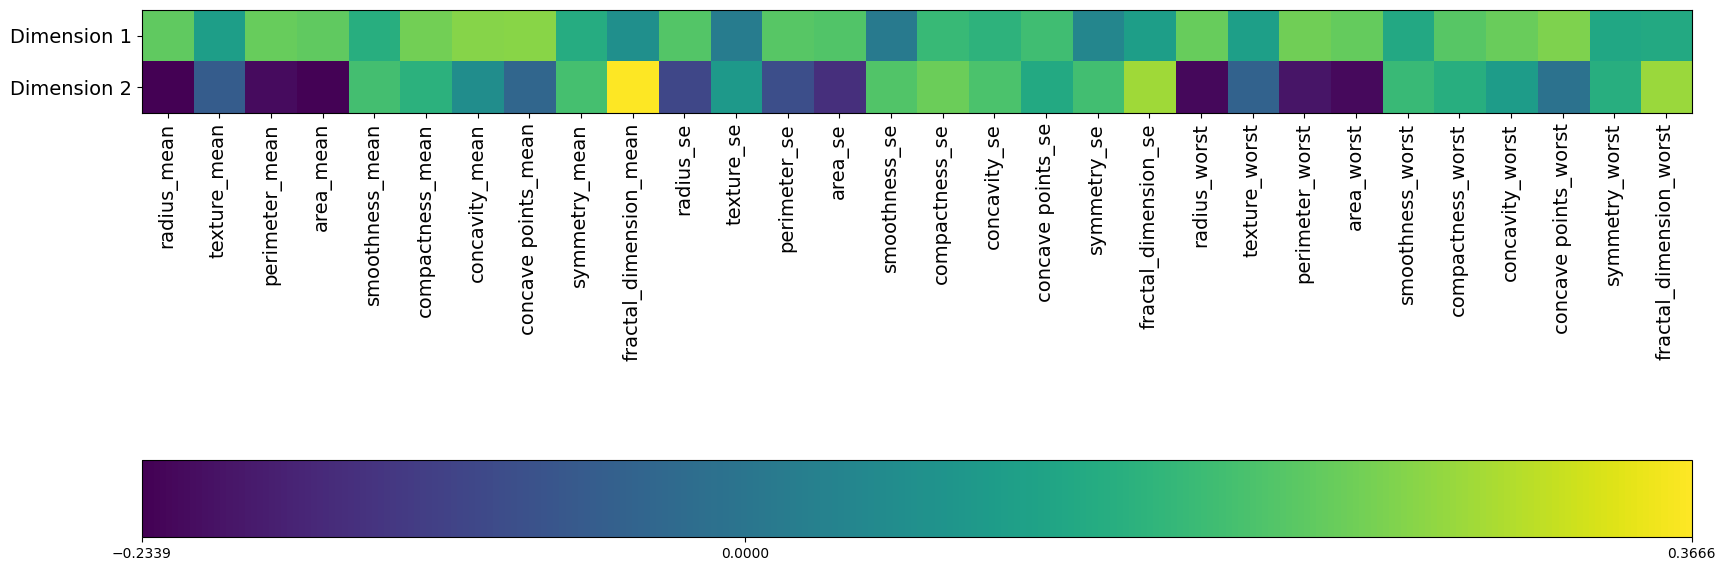

***

## **2. 이미지 데이터에서의 PCA 적용**
#### data : cifar10

### **데이터 로드**

In [11]:
# CIFAR-10 tar.gz 파일의 경로를 정의
cifar10_tar_path = './data/cifar-10-python.tar.gz'

# tar.gz 파일 추출
with tarfile.open(cifar10_tar_path, 'r:gz') as tar:
    tar.extractall()  # 파일을 현재 디렉토리로 추출
    print("Files extracted.")  # 파일이 추출되었음을 출력

# 배치 데이터를 파일에서 로드하는 함수 정의
def load_batch(file_path):
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')  # pickle을 사용하여 파일 로드
        # 이미지 데이터와 레이블 추출
        data = data_dict[b'data']  # 이미지 데이터
        labels = data_dict[b'labels']  # 레이블 데이터
        # 데이터를 이미지 형식(N, H, W, C)으로 변환 및 재배치
        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        labels = np.array(labels)  # 레이블을 NumPy 배열로 변환
    return data, labels  # 변환된 이미지와 레이블 반환

# CIFAR-10 파일이 추출된 디렉토리
cifar10_dir = 'cifar-10-batches-py'

# 훈련 데이터 로드
x_train = []  # 훈련 이미지 데이터를 저장할 리스트
y_train = []  # 훈련 레이블 데이터를 저장할 리스트
for i in range(1, 6):  # 1번 배치부터 5번 배치까지 반복
    batch_file = os.path.join(cifar10_dir, f'data_batch_{i}')  # 배치 파일 경로
    data, labels = load_batch(batch_file)  # 배치 데이터 로드
    x_train.append(data)  # 이미지 데이터를 리스트에 추가
    y_train.append(labels)  # 레이블 데이터를 리스트에 추가

# 모든 훈련 배치를 연결하여 단일 배열로 변환
x_train = np.concatenate(x_train)  # 훈련 이미지 데이터 연결
y_train = np.concatenate(y_train)  # 훈련 레이블 데이터 연결

# 테스트 데이터 로드
test_batch_file = os.path.join(cifar10_dir, 'test_batch')  # 테스트 배치 파일 경로
x_test, y_test = load_batch(test_batch_file)  # 테스트 데이터 로드

Files extracted.


### **데이터 확인**

In [ ]:
#데이터 분리


Traning data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)


((50000,), (10000,))

In [ ]:
# 클래스 확인


Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# 라벨 사전 정의
label_dict = {

}

Text(0.5, 1.0, '(Label: frog)')
Text(0.5, 1.0, '(Label: cat)')


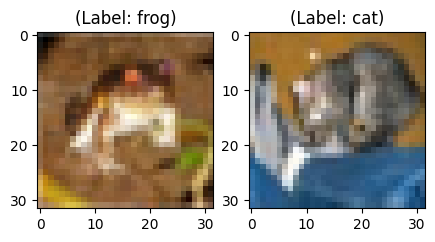

In [21]:
# 데이터 확인을 위한 시각화
plt.figure(figsize=[5,5])  # 그래프 크기 설정

# 훈련 데이터의 첫 번째 이미지 출력
plt.subplot(121)  # 첫 번째 그래프 (1행 2열 중 첫 번째 위치)
curr_img = np.reshape(x_train[0], (32, 32, 3))  # 첫 번째 훈련 데이터를 (32, 32, 3) 형식으로 재구성
plt.imshow(curr_img)  # 이미지를 표시
print(plt.title("(Label: " + str(label_dict[y_train[0]]) + ")"))  # 레이블 출력

# 테스트 데이터의 첫 번째 이미지 출력
plt.subplot(122)  # 두 번째 그래프 (1행 2열 중 두 번째 위치)
curr_img = np.reshape(x_test[0], (32, 32, 3))  # 첫 번째 테스트 데이터를 (32, 32, 3) 형식으로 재구성
plt.imshow(curr_img)  # 이미지를 표시
print(plt.title("(Label: " + str(label_dict[y_test[0]]) + ")"))  # 레이블 출력

### **2-2 데이터 Scaling**

In [ ]:
#pca를 위한 scaling


(0, 255)

In [ ]:
#scaling


NameError: name 'x_train' is not defined

In [ ]:
#3072개의 픽셀


In [ ]:
# 특징 이름 생성 (픽셀 값에 대해 열 이름 설정)
 # x_train_flat의 열 수만큼 'pixel0', 'pixel1', ... 형식의 이름 생성

# CIFAR-10 데이터를 DataFrame으로 변환
# x_train_flat 데이터를 열 이름과 함께 DataFrame으로 변환
# 레이블 데이터를 DataFrame의 새로운 열로 추가

# DataFrame 크기 출력
# DataFrame의 크기 (행, 열) 출력

Size of the dataframe: (50000, 3073)


In [27]:
df_cifar.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3063,pixel3064,pixel3065,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071,label
0,0.231373,0.243137,0.247059,0.168627,0.180392,0.176471,0.196078,0.188235,0.168627,0.266667,...,0.847059,0.721569,0.549020,0.592157,0.462745,0.329412,0.482353,0.360784,0.282353,6
1,0.603922,0.694118,0.733333,0.494118,0.537255,0.533333,0.411765,0.407843,0.372549,0.400000,...,0.560784,0.521569,0.545098,0.560784,0.525490,0.556863,0.560784,0.521569,0.564706,9
2,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.305882,0.333333,0.325490,0.309804,0.333333,0.325490,0.313725,0.337255,0.329412,9
3,0.109804,0.098039,0.039216,0.145098,0.133333,0.074510,0.149020,0.137255,0.078431,0.164706,...,0.211765,0.184314,0.109804,0.247059,0.219608,0.145098,0.282353,0.254902,0.180392,4
4,0.666667,0.705882,0.776471,0.658824,0.698039,0.768627,0.694118,0.725490,0.796078,0.717647,...,0.294118,0.309804,0.321569,0.278431,0.294118,0.305882,0.286275,0.301961,0.313725,1


### **2-3. PCA 적용**

,principal component 1,principal component 2,y
0,-6.401018,2.729039,6
1,0.829783,-0.949942,9
2,7.730200,-11.522103,9
3,-10.347817,0.010738,4
4,-2.625651,-4.969239,1


Explained variation per principal component: [0.2907663  0.11253144]


<Axes: xlabel='principal component 1', ylabel='principal component 2'>

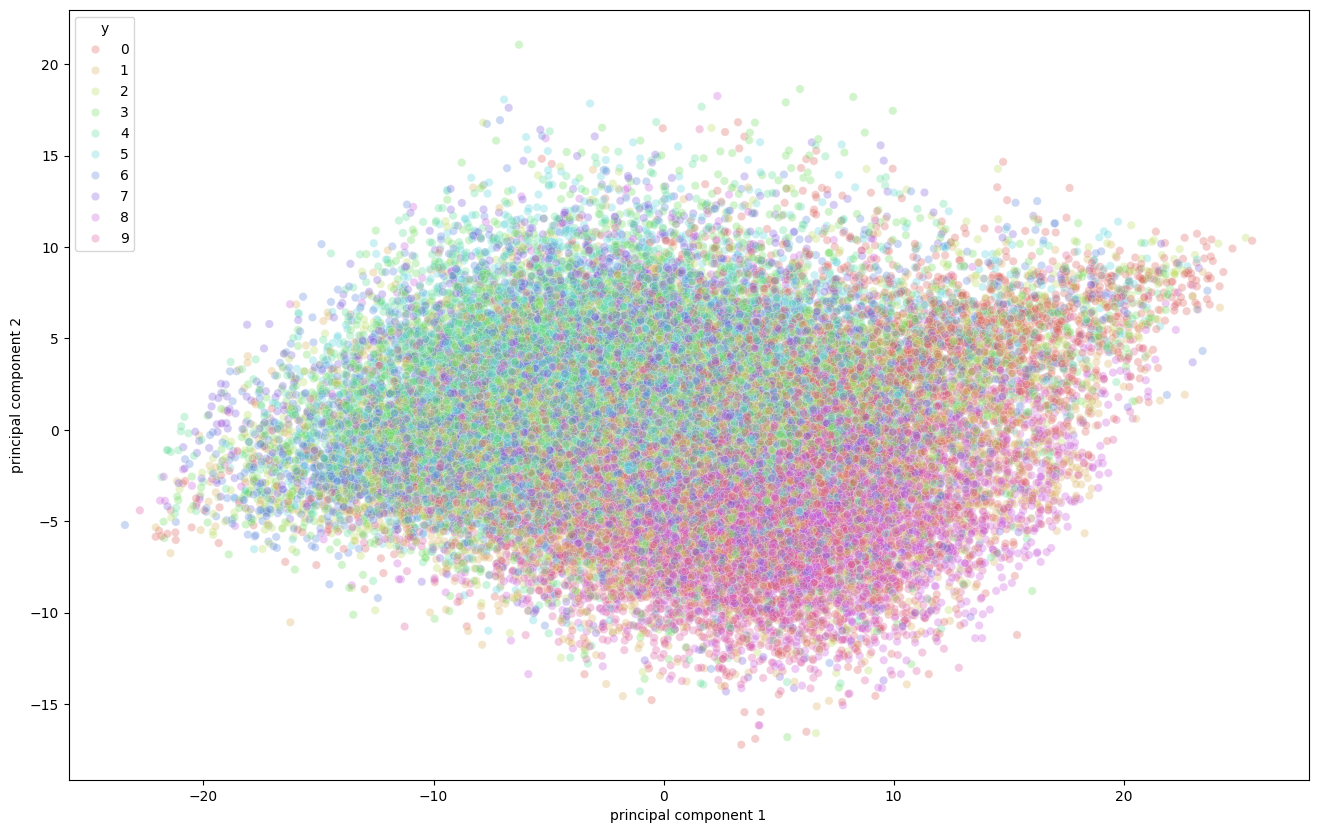

### **2-4. PCA 효과성 검증**

PCA(n_components=0.9)

99

In [ ]:
#x_train_flat: 기존 데이터
#train_img_pca: pca 적용 후 데이터


In [ ]:
# 파라미터 정의


In [ ]:
#원본 학습


2024-12-09 01:14:54.437020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-09 01:14:54.462454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-09 01:14:54.462612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/40


2024-12-09 01:14:55.831260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-09 01:14:55.849893: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa81f7d1770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-09 01:14:55.849912: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2024-12-09 01:14:55.852531: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-09 01:14:55.859096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-12-09 01:14:55.922905: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

391/391 [==============================] - 3s 4ms/step - loss: 2.1559 - accuracy: 0.1925 - val_loss: 2.0591 - val_accuracy: 0.2335
Epoch 2/40
391/391 [==============================] - 2s 4ms/step - loss: 1.9951 - accuracy: 0.2551 - val_loss: 2.0029 - val_accuracy: 0.3043
Epoch 3/40
391/391 [==============================] - 2s 4ms/step - loss: 1.9464 - accuracy: 0.2793 - val_loss: 1.9583 - val_accuracy: 0.3126
Epoch 4/40
391/391 [==============================] - 2s 5ms/step - loss: 1.9128 - accuracy: 0.2954 - val_loss: 1.9189 - val_accuracy: 0.3118
Epoch 5/40
391/391 [==============================] - 2s 5ms/step - loss: 1.8906 - accuracy: 0.3042 - val_loss: 1.8887 - val_accuracy: 0.3516
Epoch 6/40
391/391 [==============================] - 2s 5ms/step - loss: 1.8689 - accuracy: 0.3166 - val_loss: 1.8684 - val_accuracy: 0.3523
Epoch 7/40
391/391 [==============================] - 2s 5ms/step - loss: 1.8526 - accuracy: 0.3256 - val_loss: 1.8608 - val_accuracy: 0.3525
Epoch 8/40
391/39

In [ ]:
#pca 학습


Epoch 1/40
391/391 [==============================] - 2s 3ms/step - loss: 1.7667 - accuracy: 0.3669 - val_loss: 1.5377 - val_accuracy: 0.4437
Epoch 2/40
391/391 [==============================] - 1s 2ms/step - loss: 1.5478 - accuracy: 0.4509 - val_loss: 1.4190 - val_accuracy: 0.5001
Epoch 3/40
391/391 [==============================] - 1s 4ms/step - loss: 1.4550 - accuracy: 0.4825 - val_loss: 1.3701 - val_accuracy: 0.5138
Epoch 4/40
391/391 [==============================] - 1s 2ms/step - loss: 1.3905 - accuracy: 0.5061 - val_loss: 1.3152 - val_accuracy: 0.5310
Epoch 5/40
391/391 [==============================] - 2s 4ms/step - loss: 1.3366 - accuracy: 0.5258 - val_loss: 1.2967 - val_accuracy: 0.5399
Epoch 6/40
391/391 [==============================] - 1s 4ms/step - loss: 1.3000 - accuracy: 0.5384 - val_loss: 1.2799 - val_accuracy: 0.5411
Epoch 7/40
391/391 [==============================] - 2s 5ms/step - loss: 1.2712 - accuracy: 0.5504 - val_loss: 1.2640 - val_accuracy: 0.5556
Epoch 

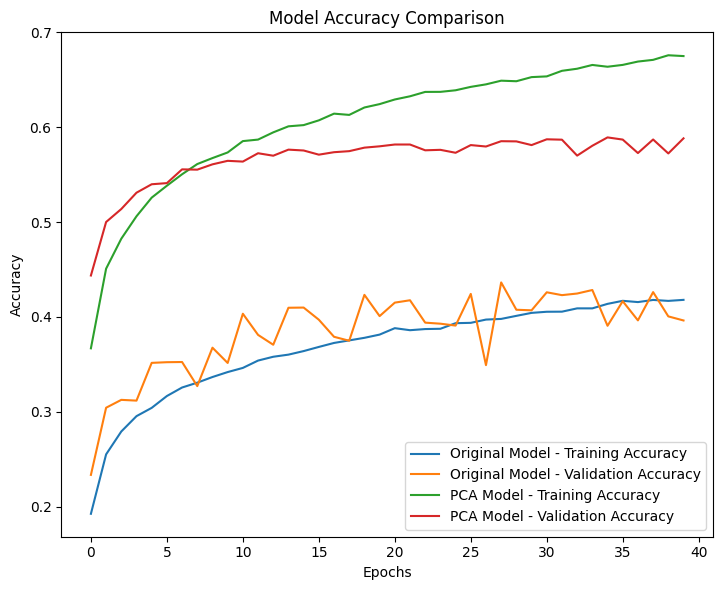

In [ ]:
# 두 모델의 정확도 확인을 위한 plot
plt.figure(figsize=(14, 6))

# 학습 정확도 및 검증 정확도 확인
